In [1]:
import os
os.chdir('./..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

from src.create_dataset_torch import *


import warnings
warnings.filterwarnings("ignore")

import shap

import pickle

In [3]:
pred = 0
imp = 'mean'

for resample in [None, 30, 60]:
    if not resample:
        data_len = 144
    elif resample == 30:
        data_len = 24
    elif resample == 60:
        data_len = 12

    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')
    data_split = np.load(os.path.join(root_folder, 'data_split.npy'), allow_pickle=True).item()
    X_train = data_split['X_train']
    y_train = data_split['y_train']
    X_val = data_split['X_val']
    y_val = data_split['y_val']
    X_test = data_split['X_test']
    y_test = data_split['y_test']

    ds_train = PatientDataset(data_folder, X_train+X_val, y_train+y_val, 
                              model_type='SVM', imputation=imp, resample_rate=resample)
    loader_train = DataLoader(ds_train, batch_size=128, 
                              sampler=ImbalancedDatasetSampler(ds_train), num_workers=8)

    ds_test = PatientDataset(data_folder, X_test, y_test, 
                             model_type='SVM', imputation=imp, resample_rate=resample)
    loader_test = DataLoader(ds_test, batch_size=128, num_workers=8)


    data_train = torch.empty((0, 4+data_len*33))
    label_train = torch.empty(0)
    for data in tqdm(loader_train):
        data_ = data['data']['static'].reshape(data['data']['static'].shape[0], -1)
        data_ = torch.concat((data_, 
                              data['data']['time_series'].reshape(data['data']['time_series'].shape[0], -1)),
                              dim=1)
        data_train = torch.concat((data_train, data_), dim=0)
        label_train = torch.concat((label_train, data['label']), dim=0)

    data_test = torch.empty((0, 4+data_len*33))
    label_test = torch.empty(0)
    for data in tqdm(loader_test):
        data_ = data['data']['static'].reshape(data['data']['static'].shape[0], -1)
        data_ = torch.concat((data_, 
                              data['data']['time_series'].reshape(data['data']['time_series'].shape[0], -1)),
                              dim=1)
        data_test = torch.concat((data_test, data_), dim=0)
        label_test = torch.concat((label_test, data['label']), dim=0)

    data_train = data_train.numpy()
    label_train = label_train.numpy()

    data_test = data_test.numpy()
    label_test = label_test.numpy()
    
    if not resample:
        resample = 5
    np.savez(os.path.join(root_folder, f'ts_aligned_stacked_{pred}_{imp}_{resample}.npz'), 
             X_train=data_train, y_train=label_train, 
             X_test=data_test, y_test=label_test,
             allow_pickle=True)

100%|██████████| 112/112 [00:25<00:00,  4.42it/s]


# Determine tree depth for different sampling frequency

In [4]:
pred = 0
imp = 'mean'

root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

# cv_score_hist = {}
# val_score_hist = {}
cv_score_hist = np.load('models/RF/cv_score_raw.npy', allow_pickle=True).item()
val_score_hist = np.load('models/RF/test_score_raw.npy', allow_pickle=True).item()

for resample in [5, 30, 60]:
    data = np.load(os.path.join(root_folder, f'ts_aligned_stacked_{pred}_{imp}_{resample}.npz'))
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

#     cv_score_hist[resample] = []
#     val_score_hist[resample] = []


    for tree_depth in tqdm(range(41, 51)):
        print(f"DEPTH {tree_depth}")
        clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
        cv_score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        cv_score_hist[resample] += [cv_score.mean()]

        clf.fit(X_train, y_train)
        val_score = clf.score(X_test, y_test)
        val_score_hist[resample] += [val_score]
        print(f'SampleRate {resample} - Tree Depth: {tree_depth} - CV Score: {cv_score} - Val Score: {val_score}')
        
        del clf
        
        np.save('models/RF/cv_score_raw.npy', cv_score_hist, allow_pickle=True)
        np.save('models/RF/test_score_raw.npy', val_score_hist, allow_pickle=True)
    
    del data
    del X_train
    del y_train
    del X_test
    del y_test

  0%|          | 0/10 [00:00<?, ?it/s]

DEPTH 41


 10%|█         | 1/10 [11:33<1:44:03, 693.74s/it]

SampleRate 5 - Tree Depth: 41 - CV Score: [0.91937683 0.91882839 0.92128223 0.91719249 0.92186648] - Val Score: 0.7973219293325855
DEPTH 42


 20%|██        | 2/10 [22:59<1:31:52, 689.11s/it]

SampleRate 5 - Tree Depth: 42 - CV Score: [0.91918208 0.91836099 0.92081483 0.91886734 0.92136013] - Val Score: 0.7987240605720696
DEPTH 43


 30%|███       | 3/10 [34:11<1:19:28, 681.20s/it]

SampleRate 5 - Tree Depth: 43 - CV Score: [0.91957157 0.91882839 0.92136013 0.91769884 0.92186648] - Val Score: 0.7976724621424566
DEPTH 44


 40%|████      | 4/10 [46:13<1:09:44, 697.42s/it]

SampleRate 5 - Tree Depth: 44 - CV Score: [0.92077897 0.91945159 0.92132118 0.91871154 0.92093168] - Val Score: 0.8045429052159282
DEPTH 45


 50%|█████     | 5/10 [57:36<57:40, 692.20s/it]  

SampleRate 5 - Tree Depth: 45 - CV Score: [0.92144109 0.91882839 0.92284023 0.91882839 0.92116538] - Val Score: 0.801668536174986
DEPTH 46


 60%|██████    | 6/10 [1:09:23<46:28, 697.09s/it]

SampleRate 5 - Tree Depth: 46 - CV Score: [0.92105161 0.91949054 0.92237283 0.91956843 0.92311288] - Val Score: 0.8006870443073472
DEPTH 47


 70%|███████   | 7/10 [1:21:06<34:57, 699.14s/it]

SampleRate 5 - Tree Depth: 47 - CV Score: [0.92116845 0.91945159 0.92248968 0.91898419 0.92330763] - Val Score: 0.803771733034212
DEPTH 48


 80%|████████  | 8/10 [1:33:00<23:27, 703.80s/it]

SampleRate 5 - Tree Depth: 48 - CV Score: [0.92144109 0.92093168 0.92284023 0.91980213 0.92361923] - Val Score: 0.8008272574312956
DEPTH 49


 90%|█████████ | 9/10 [1:44:36<11:41, 701.42s/it]

SampleRate 5 - Tree Depth: 49 - CV Score: [0.92206426 0.92019163 0.92432032 0.91980213 0.92322973] - Val Score: 0.8001261918115535
DEPTH 50


100%|██████████| 10/10 [1:56:47<00:00, 700.76s/it]

SampleRate 5 - Tree Depth: 50 - CV Score: [0.92093476 0.91976318 0.92319078 0.91968528 0.92295708] - Val Score: 0.8036315199102636



  0%|          | 0/10 [00:00<?, ?it/s]

DEPTH 41


 10%|█         | 1/10 [05:11<46:45, 311.69s/it]

SampleRate 30 - Tree Depth: 41 - CV Score: [0.92276534 0.92802057 0.92322973 0.92451507 0.92622887] - Val Score: 0.8122546270330903
DEPTH 42


 20%|██        | 2/10 [10:17<41:04, 308.10s/it]

SampleRate 30 - Tree Depth: 42 - CV Score: [0.92467381 0.92895536 0.92361923 0.92564462 0.92478772] - Val Score: 0.8136567582725743
DEPTH 43


 30%|███       | 3/10 [15:19<35:37, 305.37s/it]

SampleRate 30 - Tree Depth: 43 - CV Score: [0.92623174 0.92950066 0.92451507 0.92396977 0.92521617] - Val Score: 0.8170919798093101
DEPTH 44


 40%|████      | 4/10 [20:32<30:51, 308.51s/it]

SampleRate 30 - Tree Depth: 44 - CV Score: [0.92331061 0.92938381 0.92599517 0.92490457 0.92708577] - Val Score: 0.8149186763881099
DEPTH 45


 50%|█████     | 5/10 [25:51<26:01, 312.38s/it]

SampleRate 30 - Tree Depth: 45 - CV Score: [0.92580331 0.92961751 0.92435927 0.92451507 0.92798162] - Val Score: 0.8147083567021873
DEPTH 46


 60%|██████    | 6/10 [30:51<20:32, 308.02s/it]

SampleRate 30 - Tree Depth: 46 - CV Score: [0.92556962 0.92934486 0.92490457 0.92634572 0.92739737] - Val Score: 0.8143578238923164
DEPTH 47


 70%|███████   | 7/10 [35:46<15:11, 303.71s/it]

SampleRate 30 - Tree Depth: 47 - CV Score: [0.92494645 0.92973436 0.92455402 0.92506037 0.92747527] - Val Score: 0.8155496354458778
DEPTH 48


 80%|████████  | 8/10 [40:41<10:01, 300.99s/it]

SampleRate 30 - Tree Depth: 48 - CV Score: [0.926037   0.92957856 0.92502142 0.92622887 0.92638467] - Val Score: 0.8177930454290522
DEPTH 49


 90%|█████████ | 9/10 [45:37<04:59, 299.34s/it]

SampleRate 30 - Tree Depth: 49 - CV Score: [0.92428432 0.93024071 0.92541092 0.92615097 0.92782582] - Val Score: 0.8189848569826136
DEPTH 50


100%|██████████| 10/10 [50:44<00:00, 304.41s/it]

SampleRate 30 - Tree Depth: 50 - CV Score: [0.92572541 0.92950066 0.92618992 0.92548882 0.92747527] - Val Score: 0.8175126191811554



  0%|          | 0/10 [00:00<?, ?it/s]

DEPTH 41


 10%|█         | 1/10 [04:14<38:11, 254.60s/it]

SampleRate 60 - Tree Depth: 41 - CV Score: [0.93036027 0.93098076 0.93238296 0.92657942 0.92821532] - Val Score: 0.8299214806505889
DEPTH 42


 20%|██        | 2/10 [08:30<34:01, 255.14s/it]

SampleRate 60 - Tree Depth: 42 - CV Score: [0.92950341 0.92852691 0.9339799  0.92778687 0.92907221] - Val Score: 0.8327257431295569
DEPTH 43


 30%|███       | 3/10 [12:46<29:48, 255.49s/it]

SampleRate 60 - Tree Depth: 43 - CV Score: [0.93071081 0.93148711 0.93386305 0.92860481 0.92751422] - Val Score: 0.8326556365675827
DEPTH 44


 40%|████      | 4/10 [17:02<25:36, 256.00s/it]

SampleRate 60 - Tree Depth: 44 - CV Score: [0.93036027 0.92977331 0.9342136  0.93024071 0.92907221] - Val Score: 0.8331463825014022
DEPTH 45


 50%|█████     | 5/10 [21:19<21:21, 256.22s/it]

SampleRate 60 - Tree Depth: 45 - CV Score: [0.93180136 0.93000701 0.93409675 0.92977331 0.92981226] - Val Score: 0.8327958496915311
DEPTH 46


 60%|██████    | 6/10 [25:36<17:06, 256.67s/it]

SampleRate 60 - Tree Depth: 46 - CV Score: [0.93187926 0.93137026 0.9356937  0.92915011 0.93055231] - Val Score: 0.8349691531127313
DEPTH 47


 70%|███████   | 7/10 [30:08<13:04, 261.52s/it]

SampleRate 60 - Tree Depth: 47 - CV Score: [0.93176241 0.93339565 0.93510945 0.93047441 0.93074706] - Val Score: 0.8351794727986539
DEPTH 48


 80%|████████  | 8/10 [34:42<08:50, 265.50s/it]

SampleRate 60 - Tree Depth: 48 - CV Score: [0.93125609 0.93203241 0.9349926  0.93113656 0.93207136] - Val Score: 0.8346186203028604
DEPTH 49


 90%|█████████ | 9/10 [39:06<04:25, 265.02s/it]

SampleRate 60 - Tree Depth: 49 - CV Score: [0.93039922 0.93246086 0.9360832  0.93133131 0.93285035] - Val Score: 0.8349691531127313
DEPTH 50


100%|██████████| 10/10 [43:27<00:00, 260.73s/it]

SampleRate 60 - Tree Depth: 50 - CV Score: [0.93238559 0.93230506 0.93464205 0.93016281 0.93012386] - Val Score: 0.8335670218732474


In [2]:
cv_score_hist = np.load('models/RF/cv_score_raw.npy', allow_pickle=True).item()
val_score_hist = np.load('models/RF/test_score_raw.npy', allow_pickle=True).item()

In [5]:
len(cv_score_hist[30])

31

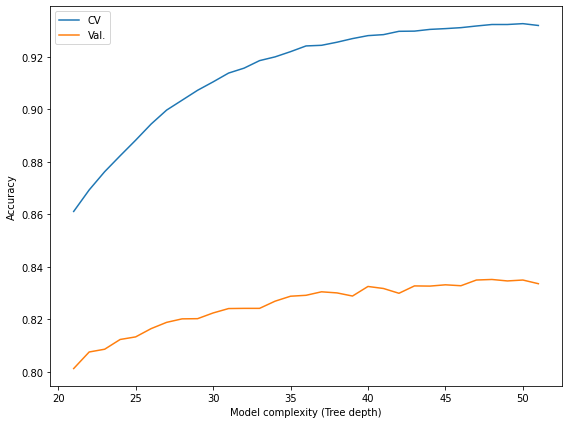

In [10]:
sample_rate = 60

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(range(21,52), cv_score_hist[sample_rate], label='CV')
plt.plot(range(21,52), val_score_hist[sample_rate], label='Val.')

ax.set_ylabel("Accuracy")
ax.set_xlabel("Model complexity (Tree depth)")
ax.legend()
fig.tight_layout()

In [ ]:
pred = 0 

root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

data = np.load(os.path.join(root_folder, 'ts_aligned_stacked.npz'))
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Random Forest

In [3]:
tree_depth=25

for pred in [0, 6, 12]:
    
    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

    data = np.load(os.path.join(root_folder, 'ts_aligned_stacked_mean.npz'))
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    clf = RandomForestClassifier(max_depth=tree_depth, random_state=0)
    clf.fit(X_train, y_train)

    save_model_path = f'models/RF/pred{pred}-impmean-sampling5-fulldim.sav'
    pickle.dump(clf, open(save_model_path, 'wb'))

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
y_pred = clf.predict(X_test)

METRICS = {
    'acc': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score,
    'auroc': roc_auc_score
}

for metric in METRICS:
    print(f'{metric}: {METRICS[metric](y_test, y_pred)}')

acc: 0.7923443634324173
recall: 0.6588533417801711
precision: 0.5245901639344263
f1: 0.5841055883178883
auroc: 0.7445702740232448


In [4]:
for pred in [0, 6, 12]:
    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

    data = np.load(os.path.join(root_folder, 'ts_aligned_stacked_mean.npz'))
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    save_model_path = f'models/RF/pred{pred}-impmean-sampling5-fulldim.sav'
    clf = pickle.load(open(save_model_path, 'rb'))

    feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                                sep=';', header=0, index_col=[0,1]).columns.to_numpy()

    # Create Tree Explainer object that can calculate shap values
    X_shap, _, y_shap, _ = train_test_split(X_test, y_test, train_size=.02, 
                                            random_state=0, shuffle=True, stratify=y_test)

    shap_explainer = shap.TreeExplainer(clf)
    shap_values = shap_explainer.shap_values(X_shap, y_shap)

    sv = np.empty(len(shap_values),dtype=object)
    sv[:] = shap_values
    np.save(f'models/RF/pred{pred}-impmean-sampling5-fulldim_shap.npy',
           sv)

In [3]:
pred = 0
root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

shap_values = np.load(f'models/RF/pred{pred}-impmean-sampling5-fulldim_shap.npy', allow_pickle=True)
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                                sep=';', header=0, index_col=[0,1]).columns.to_numpy()

shap_mean = []
shap_abs_mean = []
for sv in shap_values:
    tmp = sv[:, 4:]
    tmp = tmp.reshape(tmp.shape[0], 144, 25)
    shap_mean.append(tmp.mean(axis=1))
    shap_abs_mean.append(np.mean(np.abs(tmp), axis=1))

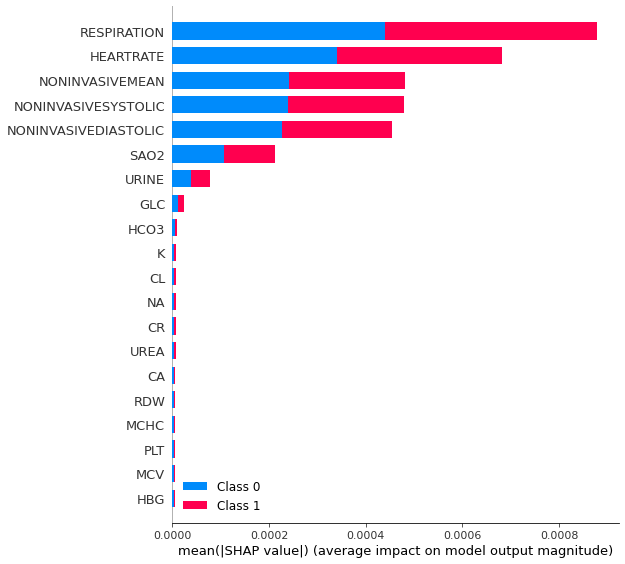

In [4]:
shap.summary_plot(shap_mean, feature_names=feature_names, plot_type='bar')

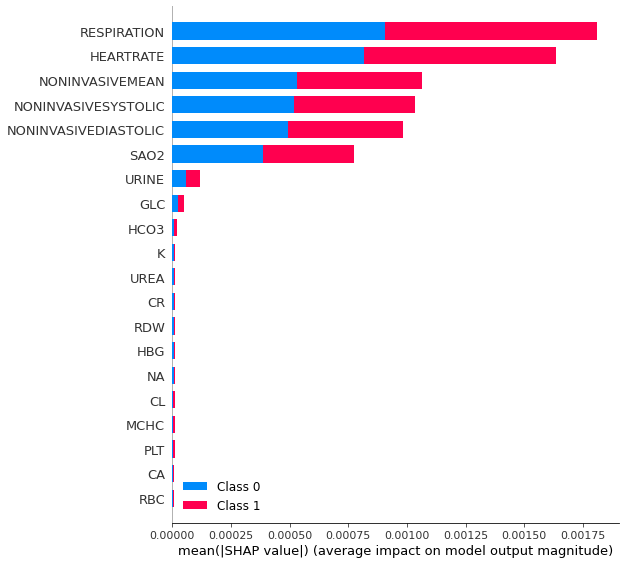

In [5]:
shap.summary_plot(shap_abs_mean, feature_names=feature_names, plot_type='bar')

# SVM

In [2]:
for pred in [0, 6, 12]:
    
    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

    data = np.load(os.path.join(root_folder, 'ts_aligned_stacked_mean.npz'))
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    clf = svm.SVC(random_state=0)
    clf.fit(X_train, y_train)

    save_model_path = f'models/SVM/pred{pred}-impmean-sampling5-fulldim.sav'
    pickle.dump(clf, open(save_model_path, 'wb'))

In [3]:
# clf = svm.SVC()
# clf.fit(X_train, y_train)

import pickle

svm_model_file = 'models/SVM/full_data.sav'
# pickle.dump(clf, open(svm_model_file, 'wb'))

clf = pickle.load(open(svm_model_file, 'rb'))

In [7]:
y_pred = clf.predict(X_test)

METRICS = {
    'acc': accuracy_score,
    'recall': recall_score,
    'precision': precision_score,
    'f1': f1_score,
    'auroc': roc_auc_score
}

for metric in METRICS:
    print(f'{metric}: {METRICS[metric](y_test, y_pred)}')

acc: 0.7477565900168256
recall: 0.7089008552423186
precision: 0.45515558267236117
f1: 0.5543720584592519
auroc: 0.7338508057610711


In [6]:
for pred in [12]:
    root_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src')
    data_folder = os.path.join(os.path.abspath('.'), f'processed/patient_data/dx_pred_{pred}_12_3src/ts_aligned')

    data = np.load(os.path.join(root_folder, 'ts_aligned_stacked_mean.npz'))
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
    save_model_path = f'models/SVM/pred{pred}-impmean-sampling5-fulldim.sav'
    clf = pickle.load(open(save_model_path, 'rb'))

    feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                                sep=';', header=0, index_col=[0,1]).columns.to_numpy()

    # Create Tree Explainer object that can calculate shap values
    X_shap, _, y_shap, _ = train_test_split(X_test, y_test, train_size=.004, 
                                            random_state=0, shuffle=True, stratify=y_test)
    
    X_shap_summary = shap.kmeans(X_train, 20)
    print('kmeans done.')
    shap_explainer = shap.KernelExplainer(clf.predict, X_shap_summary)
    shap_values = shap_explainer.shap_values(X_shap, nsamples=100)

    np.save(f'models/SVM/pred{pred}-impmean-sampling5-fulldim_shap.npy',
           shap_values)

kmeans done.


  0%|          | 0/49 [00:00<?, ?it/s]

In [7]:
shap_values = np.load(f'models/SVM/pred12-impmean-sampling5-fulldim_shap.npy')

shap_mean = []
shap_abs_mean = []

tmp = shap_values[:, 4:]
tmp = tmp.reshape(tmp.shape[0], 144, 25)
shap_mean.append(tmp.mean(axis=1))
shap_abs_mean.append(np.mean(np.abs(tmp), axis=1))

shap_values.shape, shap_mean[0].shape

((49, 3604), (49, 25))

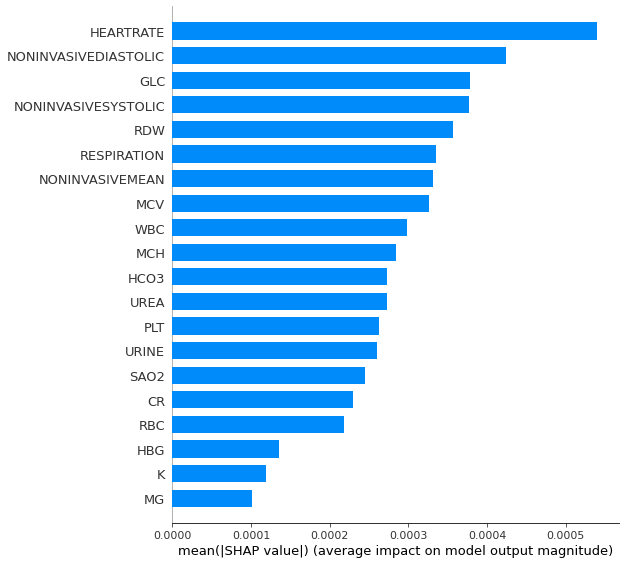

In [8]:
feature_names = pd.read_csv(os.path.join(data_folder, 'pos', 'data', os.listdir(os.path.join(data_folder, 'pos', 'data'))[0]),
                                sep=';', header=0, index_col=[0,1]).columns.to_numpy()
shap.summary_plot(shap_mean[0], feature_names=feature_names, plot_type='bar')

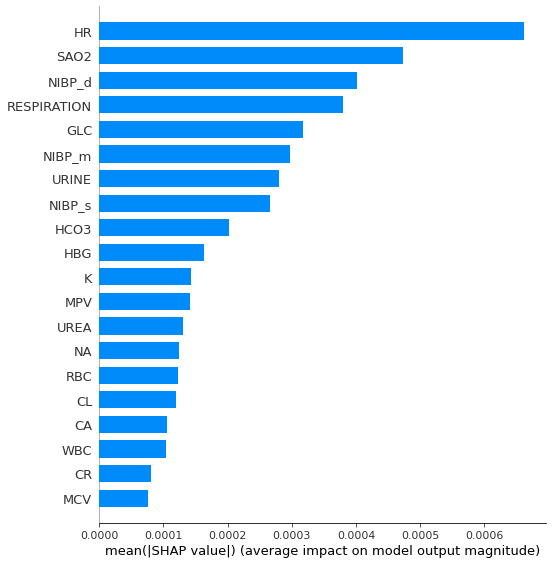

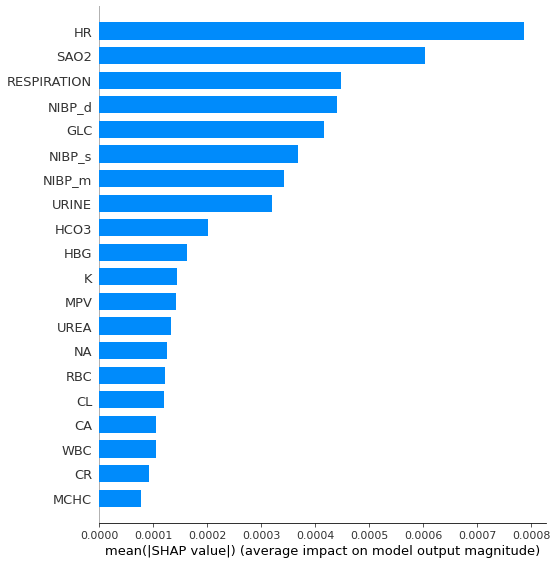

In [17]:
shap.summary_plot(shap_abs_mean[0], feature_names=feature_names, plot_type='bar')

In [19]:
np.save('plots/pred_0_12/svm_shap_values_full_data.npy', shap_values)

In [18]:
shap_values.shape

(57, 3604)